## Predict sentiment score of cryptocurrencies c with Fedot.Industrial

By combining historical sentiment data for 4 cryptocurrencies, extracted from EODHistoricalData31 and made available, with historical price data for the same cryptocurrencies, extracted from CryptoDataDownload32, was created the **BitcoinSentiment, EthereumSentiment, CardanoSentiment, and BinanceCoinSentiment** datasets, with 332, 356, 107, and 263 total instances, respectively. In all four datasets, the **predictors** are hourly **close price (in USD)** and **traded volume** for each respective cryptocurrency during a day, resulting in 2-dimensional time series of length 24. The **target variable** is the **normalized sentiment score** on the day spanned by the timepoints. The datasets were split
into train and test sets by randomly selecting 30% of each set as test data.
Link to the dataset - https://www.kaggle.com/datasets/gautamchettiar/historical-sentiment-data-btc-eth-bnb-ada

In [1]:
import pandas as pd

In [2]:
from fedot_ind.core.repository.config_repository import DEFAULT_COMPUTE_CONFIG, DEFAULT_REG_AUTOML_CONFIG, DEFAULT_AUTOML_LEARNING_CONFIG

API_CONFIG = {'industrial_config': {'problem': 'regression'},
              'automl_config': DEFAULT_REG_AUTOML_CONFIG,
              'learning_config': {'learning_strategy': 'from_scratch',
                                  'learning_strategy_params': DEFAULT_AUTOML_LEARNING_CONFIG,
                                  'optimisation_loss': {'quality_loss': 'rmse'}},
              'compute_config': DEFAULT_COMPUTE_CONFIG}
METRIC_NAMES = ('r2', 'rmse', 'mae')
DATASET_NAME = 'BitcoinSentiment'

Now we must download the dataset. It could be done by using `DataReader` class that implemented as attribute of `FedotIndustrial` class. This class firstly tries to read the data from local project folder `data_path` and then if it is not possible, it downloads the data from the UCR/UEA archive. The data will be saved in the `data` folder.

In [3]:
from fedot_ind.core.architecture.pipelines.abstract_pipeline import ApiTemplate
api_client = ApiTemplate(api_config=API_CONFIG,
                         metric_list=METRIC_NAMES)

2025-01-22 22:53:10,369 - PyTorch version 2.2.2 available.


Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train regression model.

In [12]:
result_dict = api_client.eval(dataset=DATASET_NAME, finetune=False)

Creating Dask Server
Features of basis of <class 'numpy.ndarray'> type are loaded from cache in 0.00024 sec
2025-01-22 22:54:15,039 - ApiComposer - Initial pipeline was fitted in 41.1 sec.
2025-01-22 22:54:15,040 - AssumptionsHandler - Preset was changed to fast_train due to fit time estimation for initial model.
2025-01-22 22:54:15,047 - ApiComposer - AutoML configured. Parameters tuning: False. Time limit: 10 min. Set of candidate models: ['xgbreg', 'sgdr', 'treg', 'ridge', 'lasso', 'dtreg', 'lgbmreg', 'catboostreg', 'pdl_reg', 'bagging', 'inception_model', 'resnet_model', 'channel_filtration', 'eigen_basis', 'wavelet_basis', 'fourier_basis', 'quantile_extractor', 'minirocket_extractor', 'scaling', 'normalization', 'simple_imputation', 'kernel_pca'].
2025-01-22 22:54:15,061 - ApiComposer - Timeout is too small for composing and is skipped because fit_time is 41.14253 sec.
2025-01-22 22:54:15,250 - ApiComposer - Model generation finished
2025-01-22 22:54:15,253 - FEDOT logger - Alread

In [13]:
result_dict['metrics']

,r2,rmse,mae
0,-0.031,0.277,0.215


In [14]:
opt_hist = result_dict['industrial_model'].save(return_history=True)

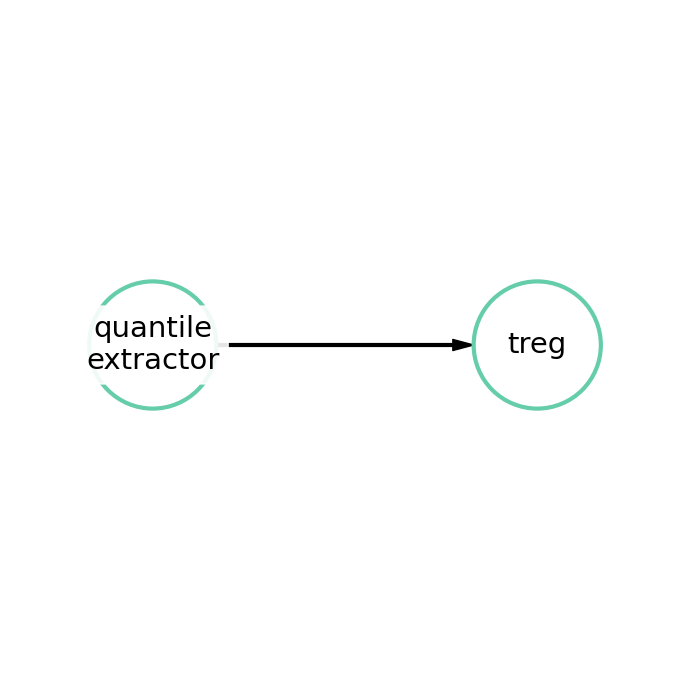

In [15]:
result_dict['industrial_model'].manager.solver.current_pipeline.show()

In [16]:
opt_hist = result_dict['industrial_model'].vis_optimisation_history(opt_history_path=opt_hist,
                                                                    mode='models',
                                                                    return_history=True)

AttributeError: 'NoneType' object has no attribute 'generations'

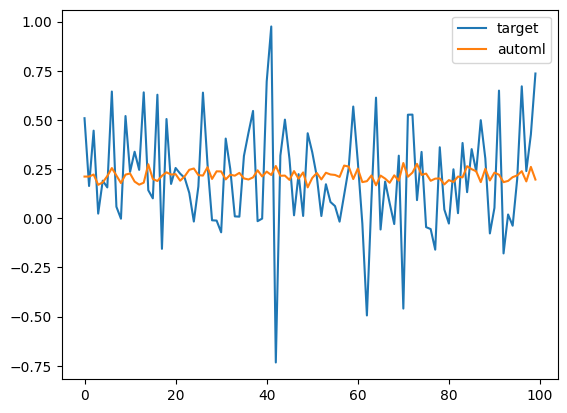

In [17]:
from matplotlib import pyplot as plt
import numpy as np

predictions = np.vstack([api_client.test_data[1].flatten(), result_dict['labels'].flatten()]).T
all_prediction = pd.DataFrame(predictions,columns=['target', 'automl'])
all_prediction.plot()
plt.show()

In [18]:
result_dict['industrial_model'].manager.solver.return_report()

,days,hours,minutes,seconds,milliseconds
Data Definition (fit),0,0,0,0,0
Data Preprocessing,0,0,0,0,0
Fitting (summary),0,0,0,8,443
Composing,0,0,0,8,252
Train Inference,0,0,0,0,1
Tuning (composing),0,0,0,0,0
Tuning (after),0,0,0,0,0
Data Definition (predict),0,0,0,0,0
Predicting,0,0,0,3,34


## Compare with State of Art (SOTA) models

In [19]:
from fedot_ind.tools.serialisation.path_lib import PROJECT_PATH
df = pd.read_csv(PROJECT_PATH + '/benchmark/ts_regression_sota_results.csv', sep=';')
df = df[df['ds/type'] == DATASET_NAME].iloc[:, :25]
df.index = df['algorithm']
df = df.drop(['algorithm', 'ds/type'], axis=1)
df = df.replace(',', '.', regex=True).astype(float)

In [20]:
df['Fedot_Industrial_AutoML'] = result_dict['metrics']['rmse'][0]
df = df.T

In [21]:
df.sort_values('max')['max']

RIST_RMSE                  0.227326
RDST_RMSE                  0.233406
DrCIF_RMSE                 0.235080
RandF_RMSE                 0.235702
5NN-ED_RMSE                0.237231
5NN-DTW_RMSE               0.238461
FreshPRINCE_RMSE           0.242154
RotF_RMSE                  0.245572
XGBoost_RMSE               0.247072
TSF_RMSE                   0.247288
MultiROCKET_RMSE           0.252652
FCN_RMSE                   0.253077
InceptionT_RMSE            0.256789
FPCR_RMSE                  0.261870
ResNet_RMSE                0.266606
FPCR-Bs_RMSE               0.270278
SingleInception_RMSE       0.273212
Fedot_Industrial_AutoML    0.277000
1NN-DTW_RMSE               0.287127
Grid-SVR_RMSE              0.289215
CNN_RMSE                   0.289748
Ridge_RMSE                 0.303183
1NN-ED_RMSE                0.308109
ROCKET_RMSE                0.322641
Name: max, dtype: float64

In [22]:
df.sort_values('average')['average']

DrCIF_RMSE                 0.197055
RandF_RMSE                 0.199306
FreshPRINCE_RMSE           0.201173
RotF_RMSE                  0.201431
RDST_RMSE                  0.202498
RIST_RMSE                  0.202756
MultiROCKET_RMSE           0.204024
5NN-ED_RMSE                0.207243
5NN-DTW_RMSE               0.207365
XGBoost_RMSE               0.208650
TSF_RMSE                   0.209727
FPCR_RMSE                  0.211556
FPCR-Bs_RMSE               0.215564
InceptionT_RMSE            0.218467
FCN_RMSE                   0.220598
SingleInception_RMSE       0.224385
ResNet_RMSE                0.226852
Ridge_RMSE                 0.232403
CNN_RMSE                   0.246243
Grid-SVR_RMSE              0.246649
1NN-DTW_RMSE               0.260328
1NN-ED_RMSE                0.264244
ROCKET_RMSE                0.268838
Fedot_Industrial_AutoML    0.277000
Name: average, dtype: float64